In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import pyaudio
import pylab
import scipy as sp
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio
pylab.rcParams['figure.figsize'] = (16, 4)

#### Utilities

In [2]:
def signal(pattern, pulse_0, pulse_1):
    pulse_0 = np.array(pulse_0);
    pulse_1 = np.array(pulse_1);
    return np.array([pulse_0 if c == 0 else pulse_1 for c in pattern]).flatten()

In [3]:
def match_decoder(signal, pulse_0, pulse_1, dt_sampling):
    match_0 = np.convolve(signal, dt_sampling-pulse_0[::-1])
    match_1 = np.convolve(signal, dt_sampling-pulse_1[::-1])
    samples_0 = match_0[np.arange(0, len(match_0), dt_sampling)]
    samples_1 = match_1[np.arange(0, len(match_1), dt_sampling)]
    return [0 if x > y else 1 for x, y in zip(samples_0, samples_1)]

In [4]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [5]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

In [6]:
def record(sec, rate):
    ex_chunk = 1024
    ex_format = pyaudio.paInt32
    ex_channel = 2

    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=ex_channel, rate=rate, input=True, frames_per_buffer=ex_chunk)
    buf = []

    for i in range(0, int(rate / ex_chunk * sec)):
        data = stream.read(ex_chunk)
        buf.append(np.fromstring(data, 'Int32'))

    stream.stop_stream()
    stream.close()
    p.terminate()

    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / ex_channel, ex_channel])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / ex_channel
    
    return ex

In [7]:
def lcs(t1, t2):
    s1 = "".join([str(c) for c in t1])
    s2 = "".join([str(c) for c in t2])
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

#### Shared parameters

In [8]:
rate = 8192

dt_sampling = 100
dt_range = np.linspace(-dt_sampling/2, dt_sampling/2, dt_sampling)
pulse_0 = np.sinc(dt_range / dt_sampling)
pulse_1 = np.sinc((dt_range - dt_sampling) / dt_sampling)

delim = np.zeros(dt_sampling) # alternating -1/1
delim[0::2] = 1
delim[1::2] = -1

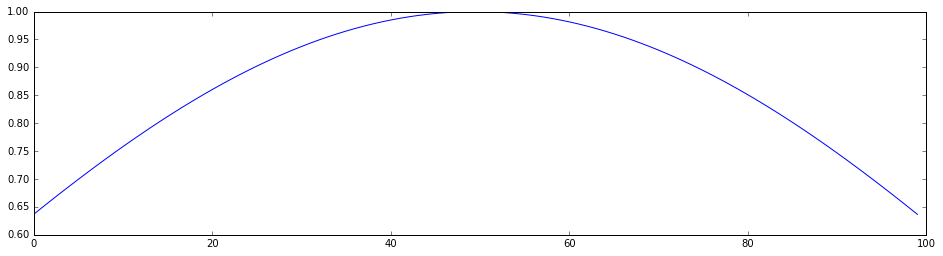

In [9]:
plt.plot(pulse_0)

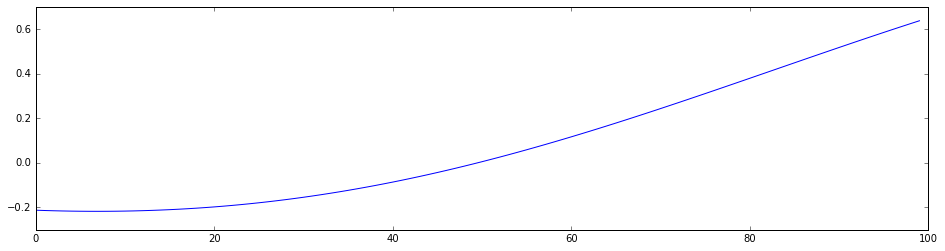

In [10]:
plt.plot(pulse_1)

#### Emitter

In [11]:
d = "The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)"
d_bin = binarize(d)
assert d == textarize(d_bin)
len(d)

137

In [12]:
dt_origin = rate

s_delay = np.zeros(dt_origin)
s_delim = signal(delim, pulse_0, pulse_1)
s_data = signal(d_bin, pulse_0, pulse_1)

s = np.concatenate((s_delay, s_delim, s_data, s_delim, s_delay))

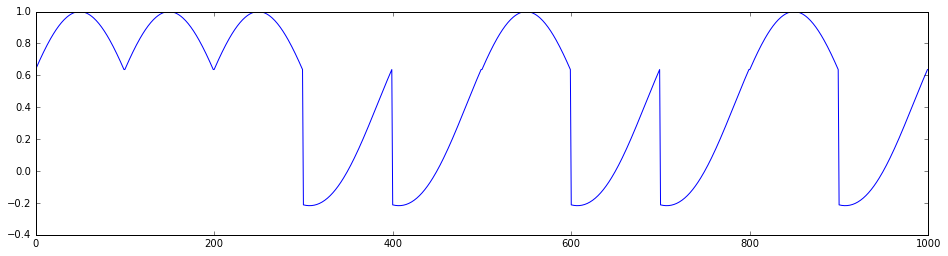

In [13]:
plt.plot(s_data[3000:4000])

In [14]:
Audio(s, rate=rate)

In [15]:
sn = s

#### Channel

In [20]:
c_rate, c = sp.io.wavfile.read("interference.wav")
assert rate == c_rate
Audio(c, rate=rate)

In [21]:
noise = record(20, rate)

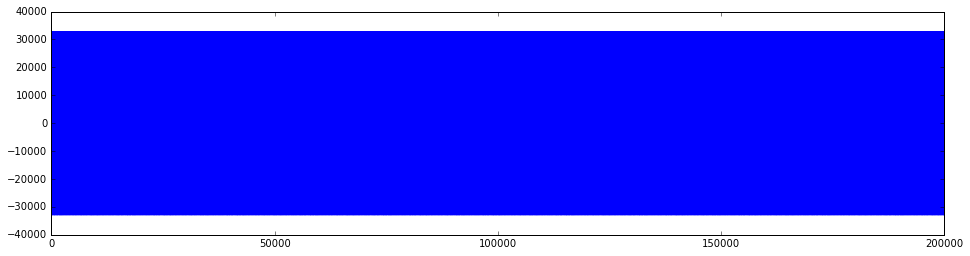

In [45]:
noise = c[:200000]
n_ampl = np.max(noise)
plt.plot(noise)
plt.show()

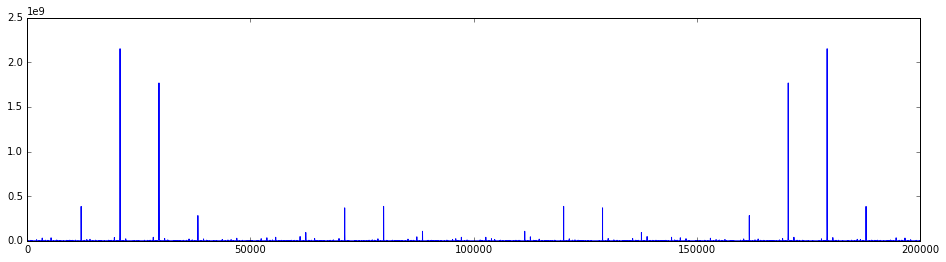

In [46]:
plt.plot(np.abs(np.fft.fft(noise)))
#zz = np.zeros(len(noise))
#zz[fs] = 2e9
#plt.plot(zz)

In [47]:
fs = np.argsort(- np.abs(np.fft.fft(noise)[:len(noise) // 2]))[:2] / len(noise) * 2 * np.pi
fs

array([ 0.65348269,  0.9273039 ])

In [51]:
[f1, f2] = fs

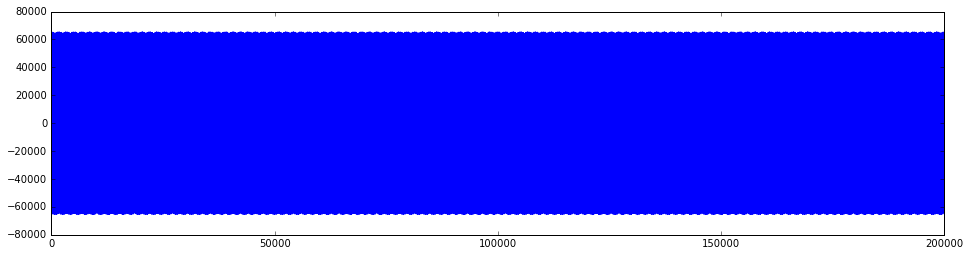

In [25]:
t = np.linspace(0, len(noise), len(noise))
sim = np.zeros(len(t))
for f in fs:
    sim += n_ampl * np.cos( f * t)

plt.plot(sim)

In [26]:
Audio(sim, rate=rate)

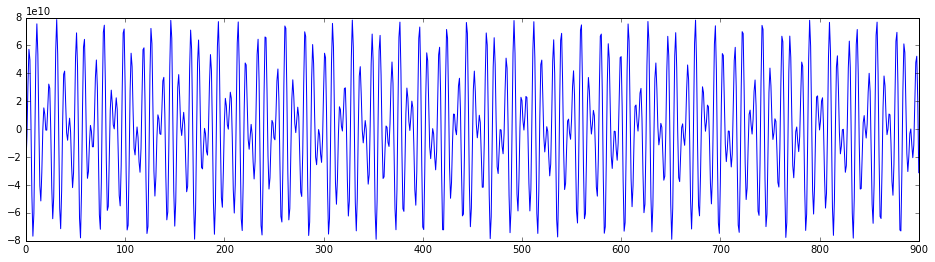

In [27]:
nx = np.correlate(noise[450:1450], sim[:100])
plt.plot(nx)
#nx
dt_noise = np.argmax(nx)

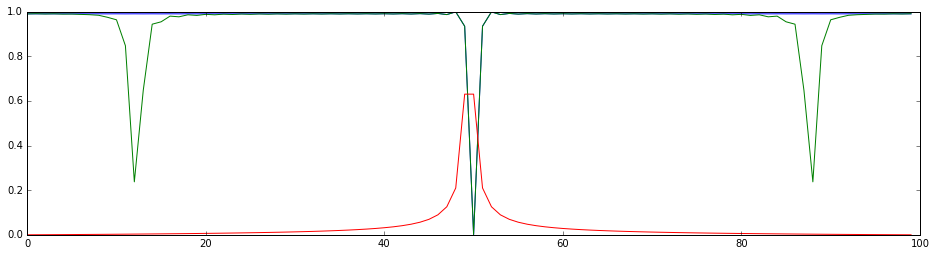

In [31]:
def bs(signal, rate, band, freq, order=2):
    nyq  = rate/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = sp.signal.iirfilter(order, [low, high], btype='bandstop', analog=False, ftype='bessel')
    return sp.signal.lfilter(b, a, signal)

ex = np.sinc(np.linspace(-100/2, 100/2, 100))
fex1 = np.fft.fft(ex)
fex2 = np.fft.fft(bs(ex, rate, 100, 1000))

fex3 = np.fft.ifft(fex1)
plt.plot(np.abs(fex1))
plt.plot(np.abs(fex2))
plt.plot(np.abs(fex3))

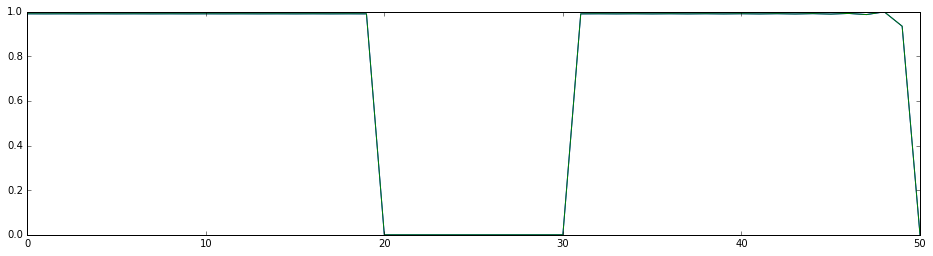

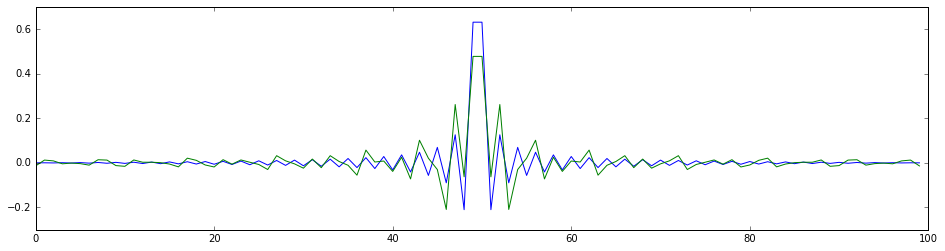

In [40]:
#plt.plot(ex)
ff = np.fft.rfft(ex)
ff[20:31] = 0
ex_r = np.fft.irfft(ff)
ff_r = np.fft.rfft(ex_r)

plt.plot(np.abs(ff))
plt.plot(np.abs(ff_r))
plt.show()

plt.plot(ex)
plt.plot(ex_r)
plt.show()

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


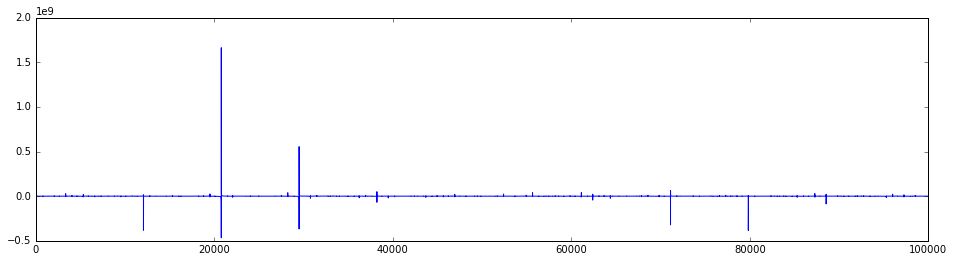

In [50]:
nfft = np.fft.rfft(noise)
plt.plot(nfft)
nfft[]

In [ ]:
plt.plot(np.abs(np.fft.fft(sim)))

In [ ]:
def lp(signal, cutoff, rate, order=6):
    nyq = 0.5 * rate
    normal_cutoff = cutoff / nyq
    b, a = sp.signal.butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, signal)
    
noise_lp = lp(noise, a, rate)
plt.plot(noise_lp)

In [ ]:
plt.plot(np.abs(np.fft.fft(noise_lp)))

#### Record

In [ ]:
recorded = record(18, rate)
Audio(recorded, rate=rate)

In [ ]:
plt.plot(recorded[3000:4000])

In [ ]:
sn = (recorded - np.percentile(recorded, 5))/(np.percentile(recorded, 95) - np.percentile(recorded, 5))

In [ ]:
plt.plot(sn[3000:4000])

#### Receiver

In [ ]:
xcorr = np.correlate(sn, s_delim)
mid = len(xcorr) // 2
start = np.argmax(xcorr[:mid])
end = len(xcorr) - np.argmax(np.flipud(xcorr[mid:]))
print(start)
print(end)

In [ ]:
plt.plot(xcorr)

In [ ]:
r_delim = sn[start:end]
r_align = match_decoder(r_delim, pulse_0, pulse_1, dt_sampling)
r = r_align[len(delim)+1:]

In [ ]:
plt.stem(r[0:100])

In [ ]:
received = textarize(r)
print(len(r))
received

In [ ]:
for d in range(0, 8):
    print(str(d) + ': ' + textarize(r[d:]))

In [ ]:
print(len(d_bin))
d

In [ ]:
lcs(d_bin, r)


#### Todos

- amplitude bounds (100Hz - 20KHz)
- mean noise subtraction
- find best amplitude
- lowerpass match
- block with parity checks


In [ ]:
ex = s

In [ ]:
plt.plot(abs(np.fft.fft(ex)))

In [ ]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

cutoff = 10
order = 6

b, a = butter_lowpass(cutoff, rate, order)
y = lfilter(b, a, ex)
plt.plot(y[0:20000])

In [ ]:
plt.hist(ex, bins=51)

In [ ]:
min(ex)

In [ ]:
max(ex)

In [ ]:
np.average(ex)

In [ ]:
T = 10
t = np.linspace(0, T, int(T * rate))
s_440 = np.sin(2 * np.pi * 440 * t)
s_261 = np.sin(2 * np.pi * 261.63 * t)

In [ ]:
Audio(s_440, rate=rate)

In [ ]:
Audio(s_261, rate=rate)

In [ ]:
s_mix = s_440 * 1000 + s_261 * 500
Audio(s_mix, rate=rate)

In [ ]:
plt.plot(s_mix[:100])